# Rastreamento de objetos e machine learning

Rastreamento de cores, objetos e aplicação de técnicas de machine learning pré-treinadas e desenvolvimento de algoritmos próprios.

Alguns recursos e códigos foram adaptados deste [repositório](https://github.com/udacity/CVND_Exercises/) do curso de Visão Computacional da Udacity.

** Importante ressaltar que precisamos do OpenCV >= 3.4.2. Pode ser instalado pelo comando**

```conda install -c conda-forge opencv```

In [5]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
print(cv2.__version__)

#Pop-up do Matplotlib
#%matplotlib qt

#Exibição na mesma tela do Jupyter
%matplotlib inline

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

3.4.2


Verificando versão instalada do OpenCV

## Rastreamento de objetos

## Filtro por cor

Calibração de cor. 

É importante ressaltar que o Gimp usa o HSV com valores H de 0 a 180 S e V de 0 a 360. O OpenCV utiliza H de 0 a 100 e S e V de 0 a 255.

In [2]:
blue = np.uint8([[[255, 0, 0]]])
hsv = cv2.cvtColor(blue,cv2.COLOR_BGR2HSV)
print(hsv)

[[[120 255 255]]]


Utilizando uma imagem estática.m

In [3]:
# Definindo limiares de cor, adotando H-10, 100, 100 para limite inferior e H+10, 255, 255 para limite superior
lower_blue = np.array([100,100,100])
upper_blue = np.array([130,255,255])

imagem = cv2.imread("imagens/caneta.jpg")
imagem = cv2.resize(imagem, (0,0), fx=0.5, fy=0.5) 

#Convertendo para HSV
hsv_img = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)

# Criação de máscara de cores dentro do limtie
mask = cv2.inRange(hsv_img, lower_blue, upper_blue)

# Operação AND entre a máscara e a imagem original
res = cv2.bitwise_and(imagem, imagem, mask=mask)

cv2.imshow('Imagem original', imagem)  
cv2.imshow('Mascara', mask)
cv2.imshow('Filtro de cor azul', res)

cv2.waitKey()
cv2.destroyAllWindows()

Utilizando captura contínua de uma webcam.

In [4]:
cap = cv2.VideoCapture(0)

# Definindo limiares de cor, adotando H-10, 100, 100 para limite inferior e H+10, 255, 255 para limite superior
lower_blue = np.array([100,100,100])
upper_blue = np.array([130,255,255])

while True:
    
    ret, frame = cap.read()
    
    if ret:
        # Os filtros foram feitos com HSV, logo precisamos converter neste spaço de cores.
        hsv_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Criação de máscara de cores dentro do limtie
        mask = cv2.inRange(hsv_img, lower_blue, upper_blue)

        # Operação AND entre a máscara e a imagem original
        res = cv2.bitwise_and(frame, frame, mask=mask)

        cv2.imshow('Imagem original', frame)  
        cv2.imshow('Mascara', mask)
        cv2.imshow('Filtro de cor azul', res)
        
    #Tecla Enter interrompe o loop
    if cv2.waitKey(1) == 13:
        break
        
cap.release()
cv2.destroyAllWindows()

Aplicando ROI.

In [5]:
cap = cv2.VideoCapture(0)

# Definindo limiares de cor, adotando H-10, 100, 100 para limite inferior e H+10, 255, 255 para limite superior
lower_blue = np.array([100,100,100])
upper_blue = np.array([130,255,255])

upper_left = (50, 50)
bottom_right = (300, 300)

while True:
    
    ret, frame = cap.read()
    
    if ret:
        
        #Rectangle marker
        r = cv2.rectangle(frame, upper_left, bottom_right, (100, 50, 200), 5)
        rect_img = frame[upper_left[1] : bottom_right[1], upper_left[0] : bottom_right[0]]
        
        hsv_img = cv2.cvtColor(rect_img, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv_img, lower_blue, upper_blue)
        res = cv2.bitwise_and(rect_img, rect_img, mask=mask)
        
        frame[upper_left[1] : bottom_right[1], upper_left[0] : bottom_right[0]] = res

        cv2.imshow('Imagem original', frame)  
        
    #Tecla Enter interrompe o loop
    if cv2.waitKey(1) == 13:
        break
        
cap.release()
cv2.destroyAllWindows()

### Rastreamento de objetos baseado em cor

Aplicando um ROI diretamente na imagem.

In [7]:
import time

#Obtendo o primeiro frame para posicionar o retângulo inicial

cap = cv2.VideoCapture("videos/soccer-ita.mp4")
play = True

while True:
    ret, frame = cap.read()
    if ret:
        cv2.imshow("Extracao ROI", frame)
        cv2.imwrite("roi_sample.png", frame)
        break
            
cv2.destroyAllWindows()
cap.release()  

In [8]:
#Escolha do ROI da imagem, neste exemplo vamos focar no juiz de vermelho

fromCenter = False
frame = cv2.imread("roi_sample.png")
r = cv2.selectROI("Image", frame, fromCenter)
roi = frame[r[1]:(r[1]+r[3]), r[0]:(r[0]+r[2])]
track_window = r[0], r[1], r[2], r[3]
cv2.imwrite("roi_sample_defined.png", roi)
cv2.imshow("Extracao ROI", roi)
cv2.waitKey(1)
cv2.destroyAllWindows()

In [9]:
track_window = r[0], r[1], r[2], r[3]

# Conversão para o espaço HSV
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# Cálculo do histograma
roi_hist = cv2.calcHist([hsv_roi], [0], None, [180], [0,180])

# Normalizar os valors para o range 0, 255
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

# Critério de término, encerrará o cálculo do centroid após 10 interações
# ou se o centróide mover, pelo menos 1 pixel
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 1)

cap = cv2.VideoCapture("videos/soccer-ita.mp4")

while True:
    ret, frame = cap.read()
    if ret:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # Cálculo do histograma da projeção da imagem em região adjacente
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # Aplicação da técnica Mean Shift na nova região
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # Incluir retângulo
        x, y, w, h = track_window
        img2 = cv2.rectangle(frame, (x,y), (x+w, y+h), 255, 2)    
        cv2.imshow('Meansift Tracking', img2)
        
        if cv2.waitKey(1) == 13: #13 is the Enter Key
            break
        time.sleep(0.01)
    else:
        break

cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()

Utilizando Meanshift

In [10]:
cap = cv2.VideoCapture(0)

# Configuração do retângulo para capturar as características do objeto a ser rastreado
r, h, c, w = 240, 100, 400, 160 
track_window = (c, r, w, h)

while True:
    ret, frame = cap.read()
    if ret:
        frame = cv2.rectangle(frame, (c,r), (c+w, r+h), 255, 2)  
        cv2.imshow("Extracao ROI", frame)
        if cv2.waitKey(1) == 13:
            break

# Recortar a região de interesse (ROI)
roi = frame[r:r+h, c:c+w]

# Conversão para o espaço HSV
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# Cálculo do histograma
roi_hist = cv2.calcHist([hsv_roi], [0], None, [180], [0,180])

# Normalizar os valors para o range 0, 255
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

# Critério de término, encerrará o cálculo do centroid após 10 interações
# ou se o centróide mover, pelo menos 1 pixel
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

while True:
    ret, frame = cap.read()
    if ret:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # Cálculo do histograma da projeção da imagem em região adjacente
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # Aplicação da técnica Mean Shift na nova região
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # Incluir retângulo
        x, y, w, h = track_window
        img2 = cv2.rectangle(frame, (x,y), (x+w, y+h), 255, 2)    
        cv2.imshow('Meansift Tracking', img2)
        
        if cv2.waitKey(1) == 13: #13 is the Enter Key
            break
    else:
        break

cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()

## Machine Learning

### Reconhecimento de caracteres (OCR)

Treinamento de classificador baseado em uma imagem de dígitos numéricos de 0 a 9.

In [11]:
# Obtendo imagem com números escritos a mão
image = cv2.imread('imagens/digits.png')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

# Convertendo em imagem menor, apenas para visualização
small = cv2.pyrDown(image)
cv2.imshow('Digits Image', small)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Dividir a imagem em 5000 células, cada uma com tamanho de 20x20
# Resulta em um array de 4 dimensões: 50 x 100 x 20 x 20
cells = [np.hsplit(row,100) for row in np.vsplit(gray,50)]

# Convertendo em um array do Numpy (50,100,20,20)
x = np.array(cells)
print ("Shape de cada célula: " + str(x.shape))

# Divisão de 70% de treinamento e 30% de testes
# Valor -1 do reshape indica que os valores serão armazenados em uma única linha
# Neste caso imagine que a matriz de cada imagem de 20 linhas x 20 colunas será convertido em uma única linha de 400 colunas
train = x[:,:70].reshape(-1,400).astype(np.float32) # Size = (3500,400)
test = x[:,70:100].reshape(-1,400).astype(np.float32) # Size = (1500,400)

print("Amostras para treino " + str(len(train)))
print("Amostras para teste " + str(len(test)))

# Labels para dados de teste
k = [0,1,2,3,4,5,6,7,8,9]
      
train_labels = np.repeat(k,350)[:,np.newaxis]
test_labels = np.repeat(k,150)[:,np.newaxis]

# Inicializando o KNN, treinando os dados e configurando com k (mínimo de vizinhos) = 3
knn = cv2.ml.KNearest_create()
knn.train(train, cv2.ml.ROW_SAMPLE, train_labels)
ret, result, neighbors, distance = knn.findNearest(test, k=3)

# Obtendo a validação do treino, comparando os resultados com os dados de teste
matches = result == test_labels
correct = np.count_nonzero(matches)
accuracy = 100 * correct/result.size

print("Precisão é de %.2f" % accuracy + " %")

Shape de cada célula: (50, 100, 20, 20)
Amostras para treino 3500
Amostras para teste 1500
Precisão é de 93.47 %


Preparando funções para identificar um dígito a partir de uma nova imagem

In [15]:
def contorno_centroide(contorno):
    # Obtem centróide X
    M = cv2.moments(contorno)
    centroide = int(M["m10"]/M["m00"])
    return centroide

In [22]:
def converter_quadrado(imagem):
    # Transforma uma imagem no formato quadrado (dimensões iguais)
    preenchimento_vazio = [0,0,0]
    
    height = imagem.shape[0]
    width = imagem.shape[1]

    if (height == width):
        return imagem
    else:
        duplicar_tamanho = cv2.resize(imagem, (2*width, 2*height), interpolation = cv2.INTER_CUBIC)
        height = height * 2
        width = width * 2
        if (height > width):
            pad = int((height - width)/2)
            duplicar_tamanho_quadrado = cv2.copyMakeBorder(duplicar_tamanho, 0, 0, pad, pad,
                                                           cv2.BORDER_CONSTANT, value=preenchimento_vazio)
        else:
            pad = int((width - height)/2)
            duplicar_tamanho_quadrado = cv2.copyMakeBorder(duplicar_tamanho, pad, pad, 0, 0,
                                                   cv2.BORDER_CONSTANT, value=preenchimento_vazio)
    
    return duplicar_tamanho_quadrado

In [2]:
from keras.models import load_model
model = load_model("modelos/model-minst.h5")  
model.load_weights("pesos/weights-minst.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4732)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               605824    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 607,394
Trainable params: 607,394
Non-trainable params: 0
_________________________________________________________________


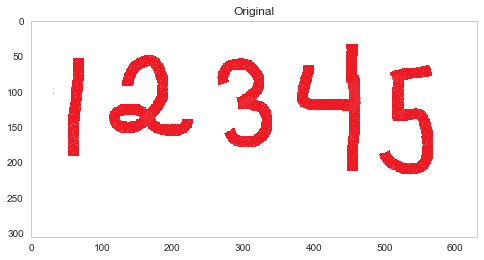

In [7]:
import numpy as np
import cv2

# Carregando imagem para detecção
imagem = cv2.imread('imagens/numeros.png')
imagem = cv2.cvtColor(imagem,cv2.COLOR_BGR2RGB)
imagem_gray = cv2.cvtColor(imagem,cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8, 10))
plt.title("Original")
plt.imshow(imagem)

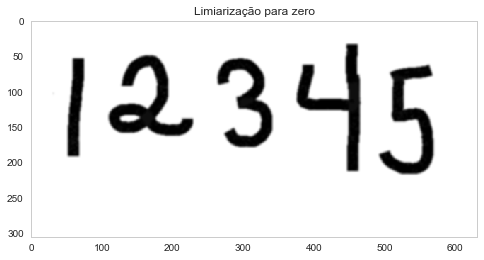

In [38]:
# Suavizando a imagem para posterior detecção de borda por Canny 

imagem_suavizada = cv2.GaussianBlur(imagem_gray, (7, 7), 0)
plt.figure(figsize=(8, 10))
plt.title("Limiarização para zero")
plt.imshow(imagem_suavizada, cmap="gray")

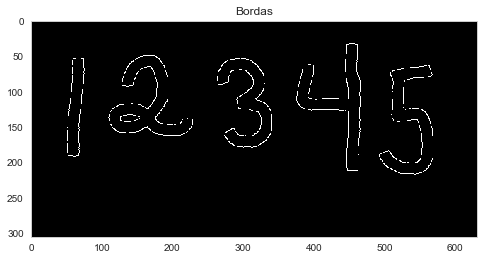

In [39]:
imagem_bordas = cv2.Canny(imagem_suavizada, 30, 150)
plt.figure(figsize=(8, 10))
plt.title("Bordas")
plt.imshow(imagem_bordas, cmap="gray")

(28, 28)
1
(28, 28)
2
(28, 28)
3
(28, 28)
4
(28, 28)
5
Numero identificado 12345


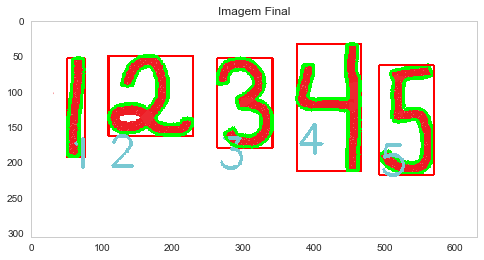

In [40]:
# Encontrando contornos
im2, contornos, hierarchy = cv2.findContours(imagem_bordas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ordenando contornos pela coordenada X
contornos = sorted(contornos, key = centroid_contour, reverse = False)

full_number = []

imagem_contornos = imagem.copy()

for c in contornos:
    # Para cada contorno, desenhar um retângulo para capturar a escrita
    (x, y, w, h) = cv2.boundingRect(c)    
    cv2.drawContours(imagem_contornos, contornos, -1, (0,255,0), 3)
    
    # Validando tamanho da imagem
    if w >= 5 and h >= 25:
        roi = imagem_suavizada[y:y + h, x:x + w]
        ret, roi = cv2.threshold(roi, 127, 255,cv2.THRESH_BINARY_INV)
        imagem_quadrado = converter_quadrado(roi)
        
        final = cv2.resize(imagem_quadrado, (28,28), interpolation = cv2.INTER_AREA)
        
        print(final.shape)
        pred = model.predict(final.reshape(1, 28, 28, 1))
        
        number = str(pred.argmax())
        full_number.append(number)
        
        # Retângulo em volta do dígito e número identificado
        cv2.rectangle(imagem_contornos, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(imagem_contornos, number, (x , y + 155), cv2.FONT_ITALIC, 2, (120, 200, 210), 3)
        print(number)

         
plt.figure(figsize=(8, 10))
plt.title("Imagem Final")
plt.imshow(imagem_contornos, cmap="gray")

print ("Numero identificado " + ''.join(full_number))

### Classificador de Faces

Gerando 100 exemplos de faces, utilizando a webcam.

In [6]:
import cv2
import numpy as np

face_classifier = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')

# Extrator de faces
def face_extractor(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.2, 5)
    
    if faces is ():
        return None
    
    for (x,y,w,h) in faces:
        cropped_face = img[y:y+h, x:x+w]

    return cropped_face

cap = cv2.VideoCapture(0)
count = 0

# Coletar 100 exemplos de um determinado rosto
while True:
    ret, frame = cap.read()
    if ret:
        cv2.imshow("Amostra", frame)
        if face_extractor(frame) is not None:
            count += 1
            face = cv2.resize(face_extractor(frame), (200, 200))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

            file_name_path = 'imagens/faces/michel/' + str(count) + '.jpg'
            cv2.imwrite(file_name_path, face)

            # Put count on images and display live count
            cv2.putText(face, str(count), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            cv2.imshow('Rosto Normalizado', face)

        if cv2.waitKey(1) == 13 or count == 100: #13 is the Enter Key
            break
        
cap.release()
cv2.destroyAllWindows()      
print("Colega de amostras completado")

Colega de amostras completado


Treinamento do modelo

In [9]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

# Carregando exemplos de arquivos previamente coletados
data_path = 'imagens/faces/michel/'
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]

training_data, labels = [], []

# Lendo as imagens e associando a um label
for i, files in enumerate(onlyfiles):
    image_path = data_path + onlyfiles[i]
    images = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    training_data.append(images)
    labels.append(0)

# Criando uma matriz da lista de labels
labels = np.asarray(labels, dtype=np.int32)

# Treinamento do modelo
model = cv2.face.LBPHFaceRecognizer_create()
#model = cv2.face.EigenFaceRecognizer_create()
model.train(training_data, labels)

print("Modelo treinado com sucesso.")

persons = {0: "Michel"}

Modelo treinado com sucesso.


Implementando modelo

In [10]:
import cv2
import numpy as np

face_classifier = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')

def face_detector(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.1, 5)
    if faces is ():
        return img, [], 0, 0
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
        roi = img[y:y+h, x:x+w]
        roi = cv2.resize(roi, (200, 200))
    return img, roi, x, y

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    image, face, x, y = face_detector(frame)
    
    try:
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        results = model.predict(face)
        
        print(results)
        
        if x > 0:
            display_string = "Dist. " + str(int(results[1])) + ' ' + persons[results[0]] 
            cv2.putText(image, display_string, (x, y-20), cv2.FONT_HERSHEY_DUPLEX, 1, (255,120,150), 2)

        if int(results[1]) < 40:
            cv2.putText(image, "Reconhecido com sucesso", (x, y-50), cv2.FONT_HERSHEY_DUPLEX, 1, (0,255,0), 2)
            cv2.imshow('Face Recognition', image)
        else:
            cv2.putText(image, "Nao reconhecido", (250, 450), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)
            cv2.imshow('Face Recognition', image)
    except:
        cv2.putText(image, "Rosto nao identificado", (220, 120) , cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)
        cv2.putText(image, "Nao reconhecido", (250, 450), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)
        cv2.imshow('Face Recognition', image )
        
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()     

(0, 38.118317469435404)
(0, 38.34760165494925)
(0, 37.838130769870425)
(0, 38.17568832954155)
(0, 37.877374278012034)
(0, 36.94028740711946)
(0, 36.780750440857254)
(0, 37.421350258682175)
(0, 37.576361588710405)
(0, 37.71325066975237)
(0, 37.32211500569863)
(0, 36.45904823468689)
(0, 37.105901697693554)
(0, 37.12610623929233)
(0, 36.28899081293288)
(0, 36.83765300378565)
(0, 37.30300871971457)
(0, 36.79097519145297)
(0, 36.84635222832929)
(0, 36.35871963161574)
(0, 35.61867431192314)
(0, 36.04858560765531)
(0, 36.29018230115487)
(0, 35.847407993521024)
(0, 32.502484249169335)
(0, 31.013332365988706)
(0, 26.820080050648652)
(0, 24.206606110261188)
(0, 26.757914845598005)
(0, 25.419716525007885)
(0, 25.079785065015084)
(0, 29.40293422044869)
(0, 26.837450212974932)
(0, 25.709704024607063)
(0, 25.42619664334167)
(0, 25.202995465385307)
(0, 25.600205888140106)
(0, 24.782492120623562)
(0, 24.34670377781189)
(0, 26.736062340756707)
(0, 123.30684338096917)
(0, 27.362073706867413)
(0, 26.8559

(0, 44.09242277893189)
(0, 47.00575802878341)
(0, 46.95019992627918)
(0, 47.670274566947604)
(0, 50.16568696732048)
(0, 48.971160891885965)
(0, 48.309343154222745)
(0, 49.60712899930063)
(0, 48.849388238864265)
(0, 49.18107899629187)
(0, 51.11603575311437)
(0, 48.948289322127984)
(0, 51.5502748324688)
(0, 49.546776084255605)
(0, 50.405415866814586)
(0, 50.575005333432294)
(0, 50.93708005355217)
(0, 51.41979186521347)
(0, 51.648201932972256)
(0, 51.884113892991564)
(0, 52.575427917567524)
(0, 57.88207060271019)
(0, 51.63591218603911)
(0, 50.93814766332212)
(0, 50.79687728112255)
(0, 49.1558448871536)
(0, 49.871354183398104)
(0, 49.87779684368234)
(0, 49.69533455657069)
(0, 50.3601681162933)
(0, 49.56539646374138)
(0, 47.9520623504157)
(0, 48.70622282483802)
(0, 50.80075106307615)
(0, 47.462222025348986)
(0, 48.30971239719539)
(0, 46.020226574292664)
(0, 50.2238777713763)
(0, 45.730367416532374)
(0, 46.81966383074332)
(0, 43.27405522546912)
(0, 44.185237344704106)
(0, 44.20842489275711)


(0, 109.87162328173484)
(0, 108.74419417639908)
(0, 109.44300002392453)
(0, 111.39091568956951)
(0, 107.35430304639313)
(0, 103.98297951413309)
(0, 117.12196676594549)
(0, 121.64772831777636)
(0, 113.57811622214128)
(0, 112.98815100418939)
(0, 123.1898142121904)
(0, 121.3100414344929)
(0, 115.21916615170444)
(0, 117.51769544585062)
(0, 110.75956027195299)
(0, 100.731603953579)
(0, 105.51501145269285)
(0, 107.19604047338974)
(0, 106.08113435838169)
(0, 131.21167586871888)
(0, 129.53721674825042)
(0, 119.14039271977991)
(0, 110.52807605222856)
(0, 104.98334291173279)
(0, 114.00333316619641)
(0, 111.35379272792258)
(0, 130.80824557467977)
(0, 127.17088827131296)
(0, 122.69739201525304)
(0, 85.58639468570041)
(0, 83.77249825516647)
(0, 83.99487407841347)
(0, 117.56777727071842)
(0, 118.64931883863653)
(0, 116.91299312301453)
(0, 116.47831884605866)
(0, 113.96240627936092)
(0, 118.8573666088128)
(0, 104.62972564160043)
(0, 109.6710841790435)
(0, 112.5923525275369)
(0, 114.08571583530247)
(0

(0, 40.818324994660735)
(0, 41.30594917801748)
(0, 40.63273154550422)
(0, 39.97127589959451)
(0, 35.17204109008305)
(0, 36.385238955387265)
(0, 35.33661345421936)
(0, 37.22776208243856)
(0, 36.51084108944292)
(0, 43.922599274876276)
(0, 46.49410358313818)
(0, 44.68279553291773)
(0, 44.1945608664663)
(0, 42.335180416602626)
(0, 42.5401237119035)
(0, 43.81567466790037)
(0, 44.85580682351845)
(0, 44.22129486419762)
(0, 45.961283688666875)
(0, 43.366981050802906)
(0, 44.381264600195)
(0, 45.00009333337847)
(0, 40.63020012505099)
(0, 40.18548581397452)
(0, 51.50514142074856)
(0, 62.82057104699709)
(0, 40.2417339235013)
(0, 39.084578312200165)
(0, 36.44937636506227)
(0, 34.697588082968224)
(0, 35.531974099467774)
(0, 38.14827212026514)
(0, 37.07267017697732)
(0, 37.98160085593781)
(0, 37.030168011339725)
(0, 38.90911860076242)
(0, 37.5347168058664)
(0, 36.3128243661112)
(0, 36.51895992409354)
(0, 36.64905777112209)
(0, 36.18555811175014)
(0, 36.758362710446896)
(0, 36.15826336498406)
(0, 35.

### Classificador Yolo (You Only Look Once)

É necessário baixar os pesos (modelo de deep-learning) neste link https://pjreddie.com/media/files/yolov3.weights e copiar para  pasta weights.

In [3]:
from utils import *
from darknet import Darknet

# Configurações na rede neural YOLOv3
cfg_file = 'cfg/yolov3.cfg'
m = Darknet(cfg_file)

# Pesos pré-treinados
weight_file = 'C:/Users/Michel.Fernandes/Downloads/yolov3.weights'
m.load_weights(weight_file)

# Rótulos de classes
namesfile = 'data/coco.names'
class_names = load_class_names(namesfile)

In [4]:
np.version.version

'1.13.3'

In [ ]:
# Topologia da rede neural da YOLOv3
m.print_network()

In [ ]:
# Tamanho da figura
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Carregando imagem para classificar
img = cv2.imread('./imagens/surf.jpg')

# Convertendo para o espaço de cores RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionando imagem para ser compatível com a primeira camada da rede neural  
resized_image = cv2.resize(original_image, (m.width, m.height))

# Exibição das imagens
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

In [ ]:
# Patamar de NMS (Non-Maximum Supression)
# Ajuste de sensibilidade de imagens com baixa luminosidade
nms_thresh = 0.6

# Patamar do IOU (Intersect of Union), indicador se o retângulo 
# de identificação de imagem foi adequadamente desenhado
iou_thresh = 0.4

In [ ]:
# Definindo tamnaho do gráfico
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Carregar imagem para classificação
img = cv2.imread('imagens/surf.jpg')

# Conversão para o espaço RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamento para adatapção da primeira camada da rede neural 
resized_image = cv2.resize(original_image, (m.width, m.height))

# Deteteção de objetos na imagem
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Objetos encontrados e nível de confiança
print_objects(boxes, class_names)

# Desenho no gráfico com os regângulos e rótulos
plot_boxes(original_image, boxes, class_names, plot_labels = True)

In [ ]:
list_objects(boxes, class_names)